## **Import Libraries**

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

# **Stage 1**

## **Data Setup & Preview** 

In [5]:
data_path = Path.home()/'notebooks/programming/data/watch_bot'
csv_path = Path.home()/'notebooks/programming/projects/watch_bot/data_prep/file_attribs.csv'

In [6]:
df = pd.read_csv(csv_path)
df = df[['name', 'dial_visibility']]
df = df.astype({'dial_visibility':'int'})
df.head(), df.dtypes

(                                                name  dial_visibility
 0  nomos_1/nomos/_without_model/nomos_@_the_loupe...                1
 1  nomos_1/nomos/_without_model/nomos_@_the_loupe...                1
 2  nomos_1/nomos/_without_model/nomos_@_the_loupe...                0
 3  nomos_1/nomos/_without_model/nomos_beta_11156_...                1
 4  nomos_1/nomos/_without_model/nomos_beta_11156_...                1,
 name               object
 dial_visibility     int64
 dtype: object)

In [7]:
bs = 64
img_size = 128
xform = get_transforms(flip_vert=True)

In [80]:
src = (ImageList.from_df(df, data_path)
        .split_by_rand_pct()
        .label_from_df())

In [81]:
data = (src.transform(tfms=xform, size=img_size, padding_mode='border')
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [45]:
print(f'{data.train_ds}\n\n{data.valid_ds}')


LabelList (9579 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
1,0,1,0,0
Path: /home/neronicolo/notebooks/programming/data/watch_bot

LabelList (2394 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
1,1,1,1,1
Path: /home/neronicolo/notebooks/programming/data/watch_bot


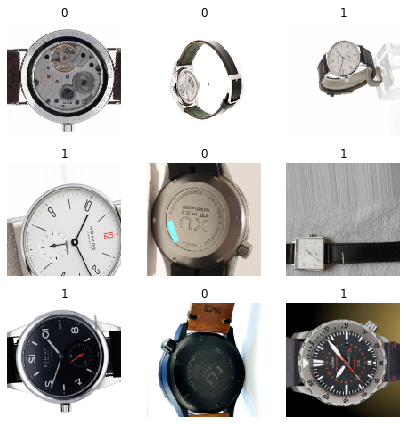

In [46]:
data.show_batch(rows=3, figsize=(6,6))

In [47]:
# TODO: resize before training - https://docs.fast.ai/vision.transform.html#resize
# look at https://nbviewer.jupyter.org/github/rsomani95/shot-type-classifier/blob/master/methodology.ipynb#Defining-Data-Transformations----

## **Training**

In [82]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy])
learn = learn.to_fp16()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


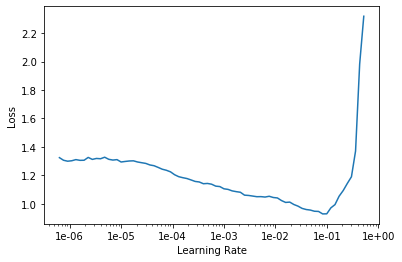

In [12]:
learn.lr_find()
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(8, slice(3e-04))

epoch,train_loss,valid_loss,accuracy,time
0,0.762612,0.383104,0.841688,01:18
1,0.458787,0.315063,0.882205,01:09
2,0.314071,0.190004,0.930242,01:09
3,0.238677,0.127303,0.955723,01:09
4,0.200137,0.127358,0.955305,01:15
5,0.165872,0.115920,0.961153,01:09
6,0.154729,0.105273,0.966583,01:09
7,0.156727,0.105844,0.967419,01:09


In [14]:
learn.save('stage_1')

## **Interpreting**

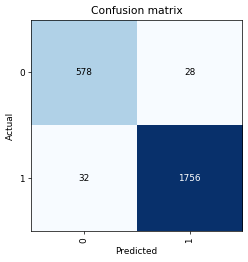

In [83]:
learn.load('stage_1')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(dpi=64)

In [50]:
def wrongly_labeled(index):
    '''Returns the list of indexes from original dataframe for top losses'''
    losses, idxs = interp.top_losses()
    top_losses_path = data.valid_ds.x[idxs[:index]].items
    name_path = [file.split('watch_bot/')[1] for file in top_losses_path]
    df_top_losses = df[df['name'].isin(name_path)]
    return df_top_losses.index.to_list()


In [51]:
losses, idxs = interp.top_losses()
len(losses) == len(idxs) == len(data.valid_ds)

True

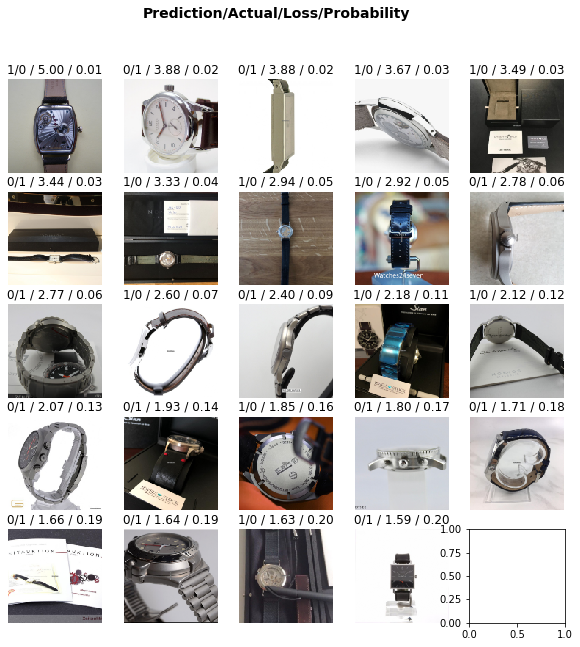

In [84]:
interp.plot_top_losses(24, figsize=(10,10))

In [86]:
print(wrongly_labeled(24))

[80, 817, 835, 1682, 1948, 3341, 4128, 4598, 5213, 5423, 5674, 5849, 5972, 7199, 7382, 7497, 8930, 9538, 9735, 9797, 10250, 10317, 10413, 11176]


1
sinn_1/sinn/u1/sinn_taucheruhr_u1-4.jpg


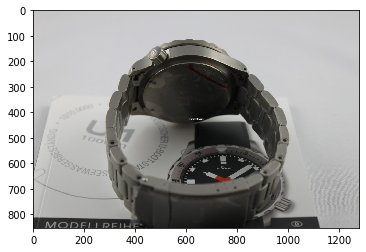

In [110]:
index = 11176
img_name = df.iloc[index]['name']
lbl_value = df.iloc[index]['dial_visibility']
img = plt.imread(data_path/img_name)
print(f'{lbl_value}\n{img_name}')
plt.imshow(img);


## **Fine Tuning**

In [21]:
learn.load('stage_1');

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


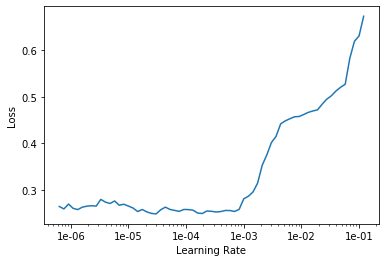

In [22]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(8, slice(1e-06, 3e-04))

epoch,train_loss,valid_loss,accuracy,time
0,0.259583,0.130804,0.956140,01:25
1,0.208333,0.152517,0.956976,01:26
2,0.162355,0.107900,0.969089,01:26
3,0.111324,0.076470,0.977861,01:26
4,0.086524,0.086575,0.978279,01:25
5,0.076577,0.073838,0.980785,01:26
6,0.071685,0.072082,0.981621,01:26
7,0.065253,0.068746,0.982456,01:26


In [24]:
learn.save('stage_1_fine_tuning')

## **Interpreting**

In [17]:
learn.load('stage_1_fine_tuning');

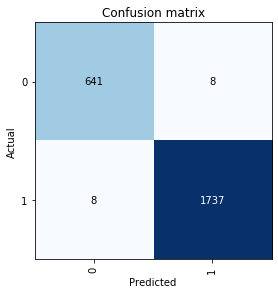

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

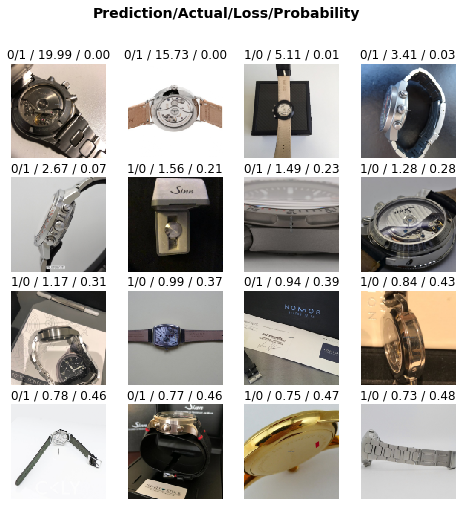

In [19]:
interp.plot_top_losses(16, figsize=(8,8))

# **Stage 2**

## **Data Setup**

In [86]:
#bs = 32
img_size = 256

In [92]:
data = (src.transform(tfms=xform, size=img_size, padding_mode='border')
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [91]:
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [100]:
learn.load('stage_1_fine_tuning');
learn = learn.to_fp16()
learn.freeze()
learn.data = data
learn.data

ImageDataBunch;

Train: LabelList (9579 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
1,1,0,1,1
Path: /home/neronicolo/notebooks/programming/data/watch_bot;

Valid: LabelList (2394 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
1,1,1,1,1
Path: /home/neronicolo/notebooks/programming/data/watch_bot;

Test: None

## **Training**

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


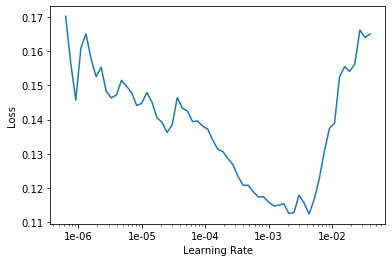

In [102]:
learn.lr_find()
learn.recorder.plot()

In [105]:
learn.fit_one_cycle(5, slice(1e-04))

epoch,train_loss,valid_loss,accuracy,time
0,0.048569,0.027024,0.990810,02:59
1,0.051541,0.031358,0.988304,03:00
2,0.057653,0.025809,0.991646,03:00
3,0.047608,0.025443,0.990393,03:00
4,0.040225,0.025458,0.991228,03:00


In [106]:
learn.save('stage_2')

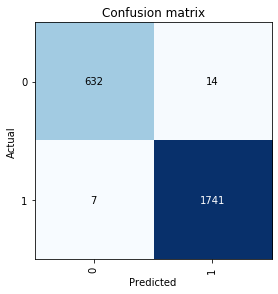

In [110]:
learn.load('stage_2');
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

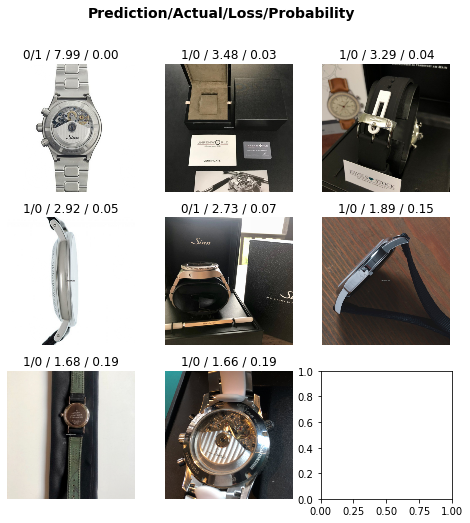

In [111]:
interp.plot_top_losses(8, figsize=(8,8))

## **Fine Tuning**

In [113]:
learn.load('stage_2');

In [116]:
learn.unfreeze()
leran = learn.to_fp16()


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


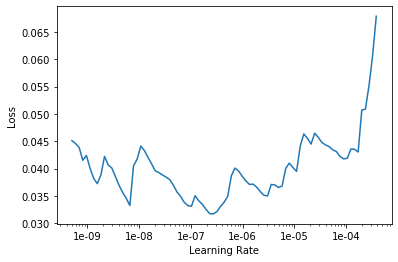

In [122]:
leran.lr_find(start_lr=1e-10, end_lr=1e-03)
learn.recorder.plot()

In [ ]:
# TODO: Re-run all cells
#       Fix wrong labeling on dataset
#       There is no need for fine tuning at this stage because we have already good accuracy. Maybe we are overfitting
#       Continue with predictions etc...